## Prerequisites

Run this cell to prepare the environment. This step is obligatory.

In [1]:
!pip install retentioneering

The full text of [Segments and clusters user guide](https://doc.retentioneering.com/stable/doc/user_guides/segments_and_clusters.html) is available on the retentioneering website.

# Segments

In [2]:
import numpy as np
import pandas as pd
import sys
from retentioneering import datasets
from retentioneering.eventstream import Eventstream

df = pd.DataFrame(
    [
        [1, 'main', 'US', 'ios', '2021-01-01 00:00:00'],
        [1, 'catalog', 'US', 'ios', '2021-01-01 00:01:00'],
        [1, 'cart', 'US', 'ios', '2021-01-01 00:02:00'],
        [1, 'purchase', 'US', 'ios', '2021-01-01 00:03:00'],
        [1, 'main', 'US', 'android', '2021-01-02 00:00:00'],
        [2, 'main', 'UK', 'web', '2021-01-01 00:00:00'],
        [2, 'catalog', 'UK', 'web', '2021-01-01 00:01:00'],
        [2, 'main', 'UK', 'web', '2021-01-02 00:00:00'],
    ],
    columns=['user_id', 'event', 'country', 'platform', 'timestamp']
)

stream = Eventstream(df, add_start_end_events=False, segment_cols=['country'])

## Segment usage example

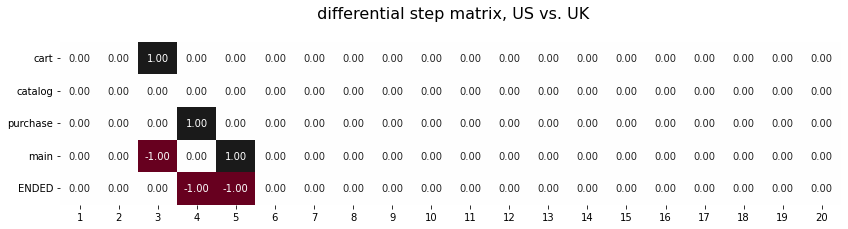

In [3]:
stream.step_matrix(groups=['country', 'US', 'UK'], threshold=0)

In [4]:
def show_pretty(df):
    df = df\
        .sort_values(['user_id', 'event_index'])\
        .reset_index(drop=True)
    main_columns = ['user_id', 'event', 'timestamp', 'event_type']
    drop_columns = ['event_id', 'event_index']
    ordered_columns = main_columns + list(set(df.columns) - set(main_columns) - set(drop_columns))
    df = df[ordered_columns]
    return df

In [5]:
stream.to_dataframe(drop_segment_events=False).pipe(show_pretty)

user_id        event           timestamp event_type platform
0        1  country::US 2021-01-01 00:00:00    segment      ios
1        1         main 2021-01-01 00:00:00        raw      ios
2        1      catalog 2021-01-01 00:01:00        raw      ios
3        1         cart 2021-01-01 00:02:00        raw      ios
4        1     purchase 2021-01-01 00:03:00        raw      ios
5        1         main 2021-01-02 00:00:00        raw  android
6        2  country::UK 2021-01-01 00:00:00    segment      web
7        2         main 2021-01-01 00:00:00        raw      web
8        2      catalog 2021-01-01 00:01:00        raw      web
9        2         main 2021-01-02 00:00:00        raw      web

## Main functions

### Segment creation

#### From column

In [6]:
stream = stream.add_segment('platform')
stream.to_dataframe(drop_segment_events=False).pipe(show_pretty)

user_id              event           timestamp event_type
0         1        country::US 2021-01-01 00:00:00    segment
1         1      platform::ios 2021-01-01 00:00:00    segment
2         1               main 2021-01-01 00:00:00        raw
3         1            catalog 2021-01-01 00:01:00        raw
4         1               cart 2021-01-01 00:02:00        raw
5         1           purchase 2021-01-01 00:03:00        raw
6         1  platform::android 2021-01-02 00:00:00    segment
7         1               main 2021-01-02 00:00:00        raw
8         2        country::UK 2021-01-01 00:00:00    segment
9         2      platform::web 2021-01-01 00:00:00    segment
10        2               main 2021-01-01 00:00:00        raw
11        2            catalog 2021-01-01 00:01:00        raw
12        2               main 2021-01-02 00:00:00        raw

#### From Series

In [7]:
user_sources = pd.Series({1: 'facebook', 2: 'organic'}, name='source')

stream.add_segment(user_sources)\
    .to_dataframe(drop_segment_events=False)\
    .pipe(show_pretty)

user_id              event           timestamp event_type
0         1        country::US 2021-01-01 00:00:00    segment
1         1      platform::ios 2021-01-01 00:00:00    segment
2         1   source::facebook 2021-01-01 00:00:00    segment
3         1               main 2021-01-01 00:00:00        raw
4         1            catalog 2021-01-01 00:01:00        raw
5         1               cart 2021-01-01 00:02:00        raw
6         1           purchase 2021-01-01 00:03:00        raw
7         1  platform::android 2021-01-02 00:00:00    segment
8         1               main 2021-01-02 00:00:00        raw
9         2        country::UK 2021-01-01 00:00:00    segment
10        2      platform::web 2021-01-01 00:00:00    segment
11        2    source::organic 2021-01-01 00:00:00    segment
12        2               main 2021-01-01 00:00:00        raw
13        2            catalog 2021-01-01 00:01:00        raw
14        2               main 2021-01-02 00:00:00        raw

#### From lambda

##### Static segment

In [8]:
def add_purchased_segment(df):
    purchased_users = df[df['event'] == 'purchase']['user_id'].unique()
    has_purchase = df['user_id'].isin(purchased_users)
    return has_purchase

stream.add_segment(segment=add_purchased_segment, name='has_purchase')\
    .to_dataframe(drop_segment_events=False)\
    .pipe(show_pretty)

user_id                event           timestamp event_type
0         1          country::US 2021-01-01 00:00:00    segment
1         1        platform::ios 2021-01-01 00:00:00    segment
2         1   has_purchase::True 2021-01-01 00:00:00    segment
3         1                 main 2021-01-01 00:00:00        raw
4         1              catalog 2021-01-01 00:01:00        raw
5         1                 cart 2021-01-01 00:02:00        raw
6         1             purchase 2021-01-01 00:03:00        raw
7         1    platform::android 2021-01-02 00:00:00    segment
8         1                 main 2021-01-02 00:00:00        raw
9         2          country::UK 2021-01-01 00:00:00    segment
10        2        platform::web 2021-01-01 00:00:00    segment
11        2  has_purchase::False 2021-01-01 00:00:00    segment
12        2                 main 2021-01-01 00:00:00        raw
13        2              catalog 2021-01-01 00:01:00        raw
14        2                 main 2021-01-02 00:00:00        raw

##### Dynamic segment

In [9]:
def first_day(df):
    df['date'] = df['timestamp'].dt.date
    df['first_day'] = df.groupby('user_id')['date'].transform('min')
    segment_values = df['date'] == df['first_day']
    return segment_values

stream\
    .add_segment(first_day, name='is_first_day')\
    .to_dataframe(drop_segment_events=False)\
    .pipe(show_pretty)

user_id                event           timestamp event_type
0         1          country::US 2021-01-01 00:00:00    segment
1         1        platform::ios 2021-01-01 00:00:00    segment
2         1   is_first_day::True 2021-01-01 00:00:00    segment
3         1                 main 2021-01-01 00:00:00        raw
4         1              catalog 2021-01-01 00:01:00        raw
5         1                 cart 2021-01-01 00:02:00        raw
6         1             purchase 2021-01-01 00:03:00        raw
7         1    platform::android 2021-01-02 00:00:00    segment
8         1  is_first_day::False 2021-01-02 00:00:00    segment
9         1                 main 2021-01-02 00:00:00        raw
10        2          country::UK 2021-01-01 00:00:00    segment
11        2        platform::web 2021-01-01 00:00:00    segment
12        2   is_first_day::True 2021-01-01 00:00:00    segment
13        2                 main 2021-01-01 00:00:00        raw
14        2              catalog 2021-01-01 00:01:00        raw
15        2  is_first_day::False 2021-01-02 00:00:00    segment
16        2                 main 2021-01-02 00:00:00        raw

### Segment materizlization

In [10]:
stream.materialize_segment('platform')\
    .to_dataframe(drop_segment_events=False)\
    .pipe(show_pretty)

user_id              event           timestamp event_type platform
0         1        country::US 2021-01-01 00:00:00    segment      ios
1         1      platform::ios 2021-01-01 00:00:00    segment      ios
2         1               main 2021-01-01 00:00:00        raw      ios
3         1            catalog 2021-01-01 00:01:00        raw      ios
4         1               cart 2021-01-01 00:02:00        raw      ios
5         1           purchase 2021-01-01 00:03:00        raw      ios
6         1  platform::android 2021-01-02 00:00:00    segment  android
7         1               main 2021-01-02 00:00:00        raw  android
8         2        country::UK 2021-01-01 00:00:00    segment      web
9         2      platform::web 2021-01-01 00:00:00    segment      web
10        2               main 2021-01-01 00:00:00        raw      web
11        2            catalog 2021-01-01 00:01:00        raw      web
12        2               main 2021-01-02 00:00:00        raw      web

### Segment removal

In [11]:
stream.drop_segment('platform')\
    .to_dataframe(drop_segment_events=False)\
    .pipe(show_pretty)

user_id        event           timestamp event_type
0        1  country::US 2021-01-01 00:00:00    segment
1        1         main 2021-01-01 00:00:00        raw
2        1      catalog 2021-01-01 00:01:00        raw
3        1         cart 2021-01-01 00:02:00        raw
4        1     purchase 2021-01-01 00:03:00        raw
5        1         main 2021-01-02 00:00:00        raw
6        2  country::UK 2021-01-01 00:00:00    segment
7        2         main 2021-01-01 00:00:00        raw
8        2      catalog 2021-01-01 00:01:00        raw
9        2         main 2021-01-02 00:00:00        raw

### Segment filtering

In [12]:
stream.filter_events(segment=['country', 'UK'])\
    .to_dataframe(drop_segment_events=False)\
    .pipe(show_pretty)

user_id          event           timestamp event_type
0        2    country::UK 2021-01-01 00:00:00    segment
1        2  platform::web 2021-01-01 00:00:00    segment
2        2           main 2021-01-01 00:00:00        raw
3        2        catalog 2021-01-01 00:01:00        raw
4        2           main 2021-01-02 00:00:00        raw

### Segment renaming

In [13]:
stream.rename_segment(old_name='country', new_name='user_country')\
    .to_dataframe(drop_segment_events=False)\
    .pipe(show_pretty)

user_id              event           timestamp event_type
0         1   user_country::US 2021-01-01 00:00:00    segment
1         1      platform::ios 2021-01-01 00:00:00    segment
2         1               main 2021-01-01 00:00:00        raw
3         1            catalog 2021-01-01 00:01:00        raw
4         1               cart 2021-01-01 00:02:00        raw
5         1           purchase 2021-01-01 00:03:00        raw
6         1  platform::android 2021-01-02 00:00:00    segment
7         1               main 2021-01-02 00:00:00        raw
8         2   user_country::UK 2021-01-01 00:00:00    segment
9         2      platform::web 2021-01-01 00:00:00    segment
10        2               main 2021-01-01 00:00:00        raw
11        2            catalog 2021-01-01 00:01:00        raw
12        2               main 2021-01-02 00:00:00        raw

### Segment values renaming

In [14]:
mapping_dict = {
    'US': 'United States',
    'UK': 'United Kingdom'
}

stream.remap_segment(name='country', mapping=mapping_dict)\
    .to_dataframe(drop_segment_events=False)\
    .pipe(show_pretty)

user_id                    event           timestamp event_type
0         1   country::United States 2021-01-01 00:00:00    segment
1         1            platform::ios 2021-01-01 00:00:00    segment
2         1                     main 2021-01-01 00:00:00        raw
3         1                  catalog 2021-01-01 00:01:00        raw
4         1                     cart 2021-01-01 00:02:00        raw
5         1                 purchase 2021-01-01 00:03:00        raw
6         1        platform::android 2021-01-02 00:00:00    segment
7         1                     main 2021-01-02 00:00:00        raw
8         2  country::United Kingdom 2021-01-01 00:00:00    segment
9         2            platform::web 2021-01-01 00:00:00    segment
10        2                     main 2021-01-01 00:00:00        raw
11        2                  catalog 2021-01-01 00:01:00        raw
12        2                     main 2021-01-02 00:00:00        raw

### Segment mapping

In [15]:
stream.segment_map(name='country', index='path_id')

user_id
1    US
2    UK
Name: segment_value, dtype: object

In [16]:
stream.segment_map(name='country', index='segment_value')

segment_value
UK    2
US    1
Name: user_id, dtype: int64

In [17]:
stream.segment_map('platform')

user_id
1        ios
1    android
2        web
Name: segment_value, dtype: object

In [18]:
stream.segment_map(name='platform', index='path_id', resolve_collision='majority')

user_id
1    ios
2    web
Name: segment_value, dtype: object

In [19]:
stream.segment_map(name=None)

user_id segment_name segment_value
0        1      country            US
1        1     platform           ios
2        1     platform       android
3        2      country            UK
4        2     platform           web

## Segment usage

In [20]:
stream2 = datasets.load_simple_shop()

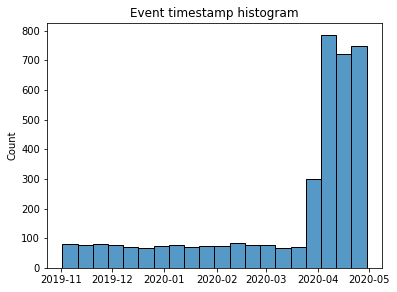

In [21]:
stream2.event_timestamp_hist(event_list=['path_start'])

In [22]:
def add_segment_by_date(df):
    first_day = df.groupby('user_id')['timestamp'].min()
    target_users = first_day[first_day < '2020-04-01'].index
    segment_values = df['user_id'].isin(target_users)
    segment_values = segment_values.map({True: 'Before', False: 'After'})
    return segment_values

stream2 = stream2.add_segment(add_segment_by_date, name='Apr 2020')

In [23]:
stream2.to_dataframe(drop_segment_events=False).head(10).pipe(show_pretty)

user_id             event                  timestamp  event_type
0  219483890  Apr 2020::Before 2019-11-01 17:59:13.273932     segment
1  219483890        path_start 2019-11-01 17:59:13.273932  path_start
2  219483890           catalog 2019-11-01 17:59:13.273932         raw
3  219483890          product1 2019-11-01 17:59:28.459271         raw
4  219483890              cart 2019-11-01 17:59:29.502214         raw
5  219483890           catalog 2019-11-01 17:59:32.557029         raw
6  964964743  Apr 2020::Before 2019-11-01 21:38:19.283663     segment
7  964964743        path_start 2019-11-01 21:38:19.283663  path_start
8  964964743           catalog 2019-11-01 21:38:19.283663         raw
9  964964743              cart 2019-11-01 21:38:36.761221         raw

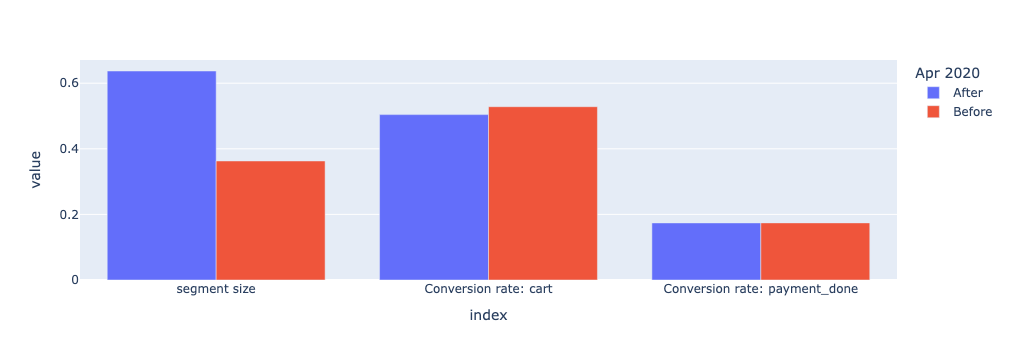

In [24]:
custom_metrics = [
    ('segment_size', 'mean', 'segment size'),
    ('has:cart', 'mean', 'Conversion rate: cart'),
    ('has:payment_done', 'mean', 'Conversion rate: payment_done')
]
stream2.segment_overview('Apr 2020', metrics=custom_metrics, kind='bar', axis=1)

In [25]:
stream2.filter_events(segment=['Apr 2020', 'Before']).path_metrics(('time_to:payment_done', 'tt_payment')).median()

Timedelta('0 days 00:02:53.153558')

In [26]:
stream2.filter_events(segment=['Apr 2020', 'After']).path_metrics(('time_to:payment_done', 'tt_payment')).median()

Timedelta('0 days 00:01:21.193424500')

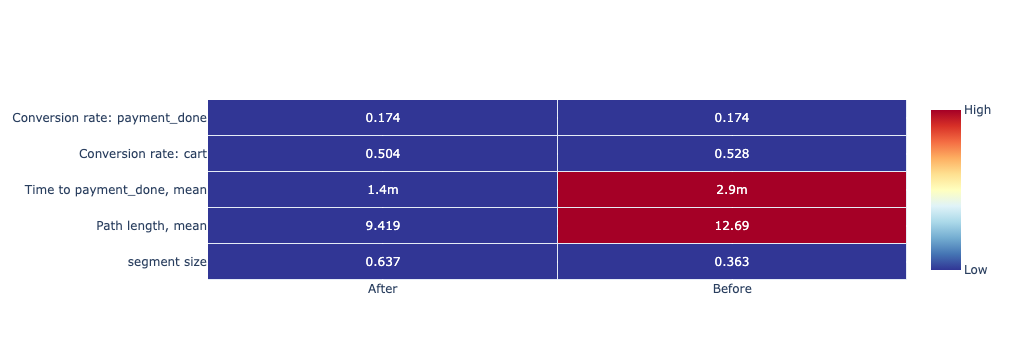

In [27]:
custom_metrics = [
    ('segment_size', 'mean', 'segment size'),
    ('len', 'mean', 'Path length, mean'),
    ('time_to:payment_done', pd.Series.median, 'Time to payment_done, mean'),
    ('has:cart', 'mean', 'Conversion rate: cart'),
    ('has:payment_done', 'mean', 'Conversion rate: payment_done')
]
stream2.segment_overview('Apr 2020', metrics=custom_metrics, kind='heatmap')

In [28]:
stream2.segment_overview('Apr 2020', metrics=custom_metrics, kind='heatmap', show_plot=False).values

Apr 2020                       After Before
segment size                   0.637  0.363
Path length, mean              9.419  12.69
Time to payment_done, mean      1.4m   2.9m
Conversion rate: cart          0.504  0.528
Conversion rate: payment_done  0.174  0.174

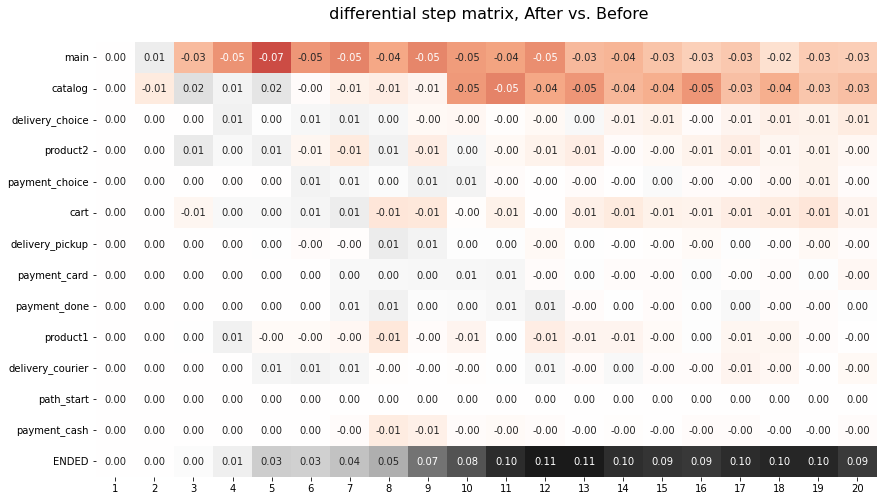

In [29]:
stream2.step_matrix(groups='Apr 2020', threshold=0)

/Users/v.kukushkin/rete/retentioneering-tools-new-arch/retentioneering/nodelist/nodelist.py:96: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

/Users/v.kukushkin/rete/retentioneering-tools-new-arch/retentioneering/tooling/transition_matrix/transition_matrix.py:137: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/Users/v.kukushkin/rete/retentioneering-tools-new-arch/retentioneering/nodelist/nodelist.py:96: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, th

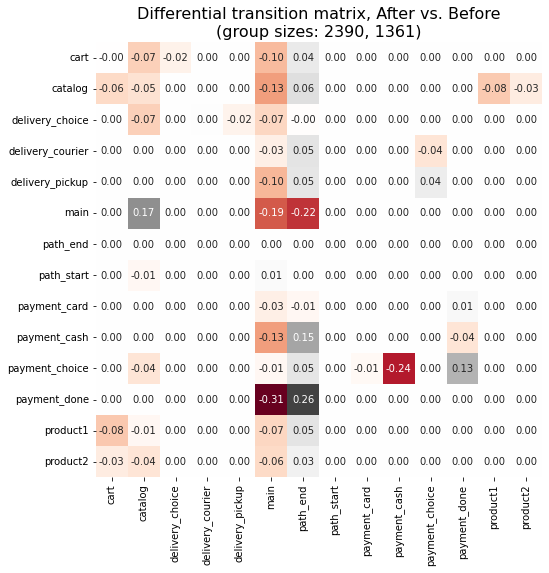

In [30]:
stream2.transition_matrix(groups='Apr 2020', norm_type='node')

## Clusters

### Vectorization

In [31]:
features = stream2.extract_features(ngram_range=(1, 1), feature_type='count')

features[['main', 'catalog', 'cart', 'payment_done']].head()

main  catalog  cart  payment_done
user_id                                   
122915      7       18     1             0
463458      1        8     0             0
1475907     2        5     1             0
1576626     1        0     0             0
2112338     2        3     0             0

### Clustering algorithms

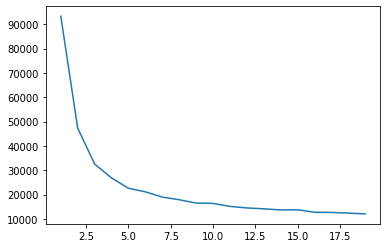

In [32]:
stream2.get_clusters(features, method='kmeans')

In [33]:
stream2 = stream2.get_clusters(features, method='kmeans', n_clusters=8, random_state=42, segment_name='kmeans_clusters')

In [34]:
stream2.to_dataframe(drop_segment_events=False).head(10)

event_id  event_type  event_index  \
0  01f76d94-075a-4b94-a186-3cbb5e184c00     segment            0   
1  71aca883-bf79-4091-9df1-204166f72e23     segment            0   
2  8815d878-f4e4-435a-a8e4-2b98c3fee43c  path_start            0   
3  8815d878-f4e4-435a-a8e4-2b98c3fee43c         raw            0   
4  e0d25034-a47d-47c6-8aa5-6c699c97fa8d         raw            1   
5  9b485fbb-689f-4e58-9b5d-c39f81673c58         raw            2   
6  a70907e7-22bf-4588-a14f-1a7045bcfd51         raw            3   
7  90719f1d-3da8-43e0-b7fb-681044a3c672     segment            4   
8  59b557f6-f601-4463-89d6-3e42f9a1af84     segment            4   
9  56ba955d-ad74-482a-a9cb-3ec4d0d6d8f4  path_start            4   

                event                  timestamp    user_id  
0    Apr 2020::Before 2019-11-01 17:59:13.273932  219483890  
1  kmeans_clusters::4 2019-11-01 17:59:13.273932  219483890  
2          path_start 2019-11-01 17:59:13.273932  219483890  
3             catalog 2019-11-01 17:59:13.273932  219483890  
4            product1 2019-11-01 17:59:28.459271  219483890  
5                cart 2019-11-01 17:59:29.502214  219483890  
6             catalog 2019-11-01 17:59:32.557029  219483890  
7    Apr 2020::Before 2019-11-01 21:38:19.283663  964964743  
8  kmeans_clusters::1 2019-11-01 21:38:19.283663  964964743  
9          path_start 2019-11-01 21:38:19.283663  964964743

### Cluster analysis

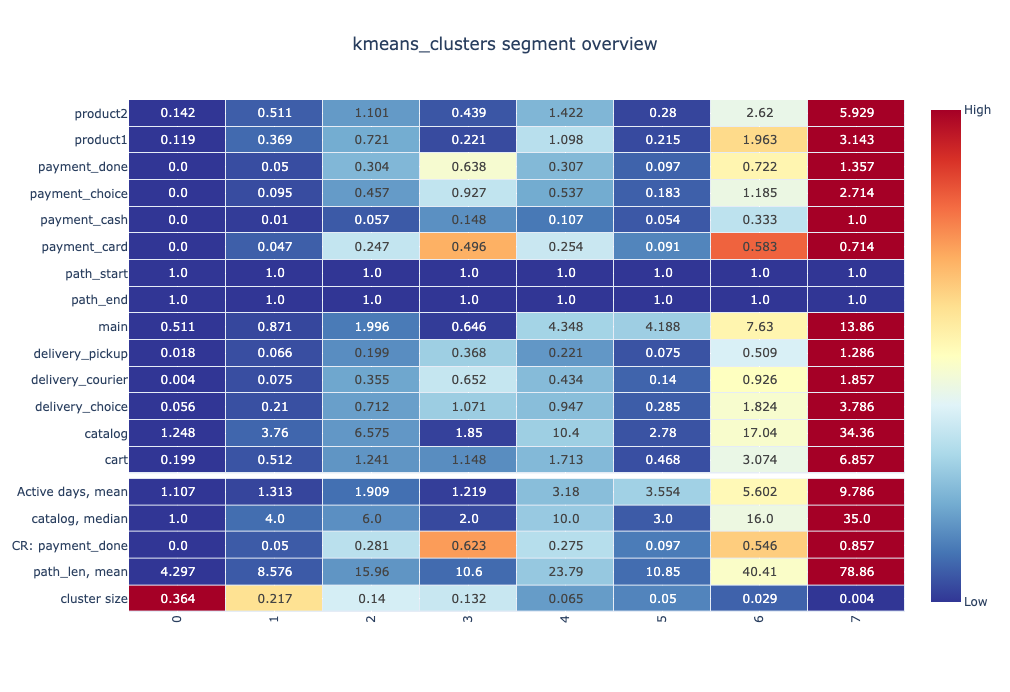

In [35]:
custom_metrics = [
    ('segment_size', 'mean', 'cluster size'),
    ('len', 'mean', 'path_len, mean'),
    ('has:payment_done', 'mean', 'CR: payment_done'),
    (lambda _df: (_df['event'] == 'catalog').sum(), 'median', 'catalog, median'),
    (pd.NamedAgg('timestamp', lambda s: len(s.dt.date.unique())), 'mean', 'Active days, mean')
]

stream2.clusters_overview('kmeans_clusters', features, aggfunc='mean', metrics=custom_metrics)

In [36]:
stream2.segment_diff(['kmeans_clusters', '2', '4'], features)

In [37]:
stream2.segment_diff(['kmeans_clusters', '2', '_OUTER_'], features)

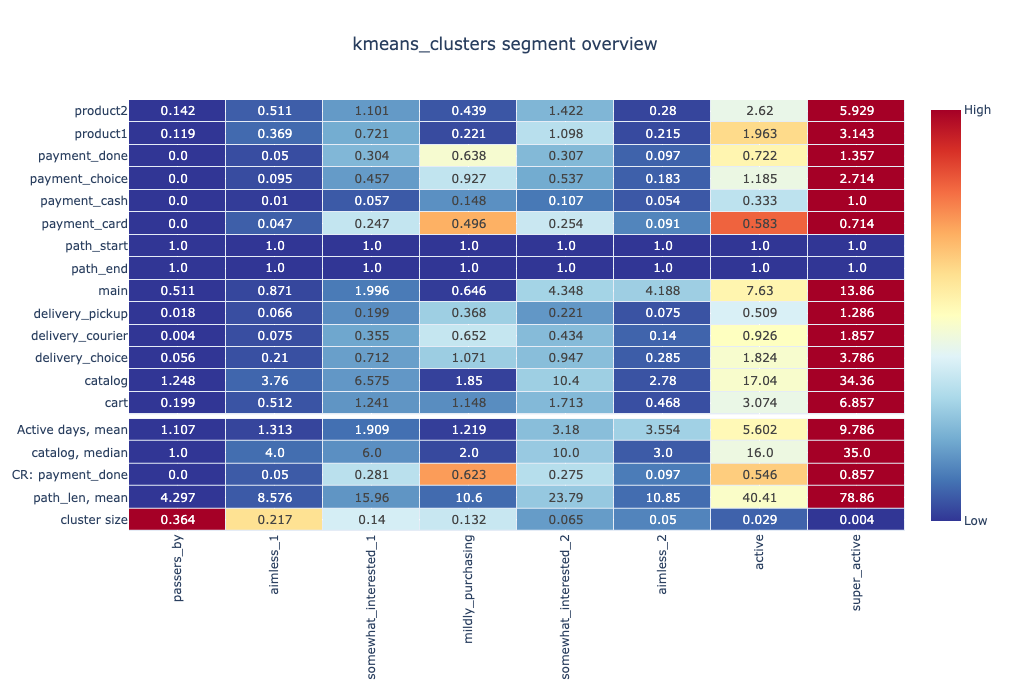

In [38]:
cluster_labels = {
    '0': 'passers_by',
    '1': 'aimless_1',
    '2': 'somewhat_interested_1',
    '3': 'mildly_purchasing',
    '4': 'somewhat_interested_2',
    '5': 'aimless_2',
    '6': 'active',
    '7': 'super_active'
}
stream2 = stream2.remap_segment('kmeans_clusters', cluster_labels)
stream2.clusters_overview('kmeans_clusters', features, aggfunc='mean', metrics=custom_metrics)

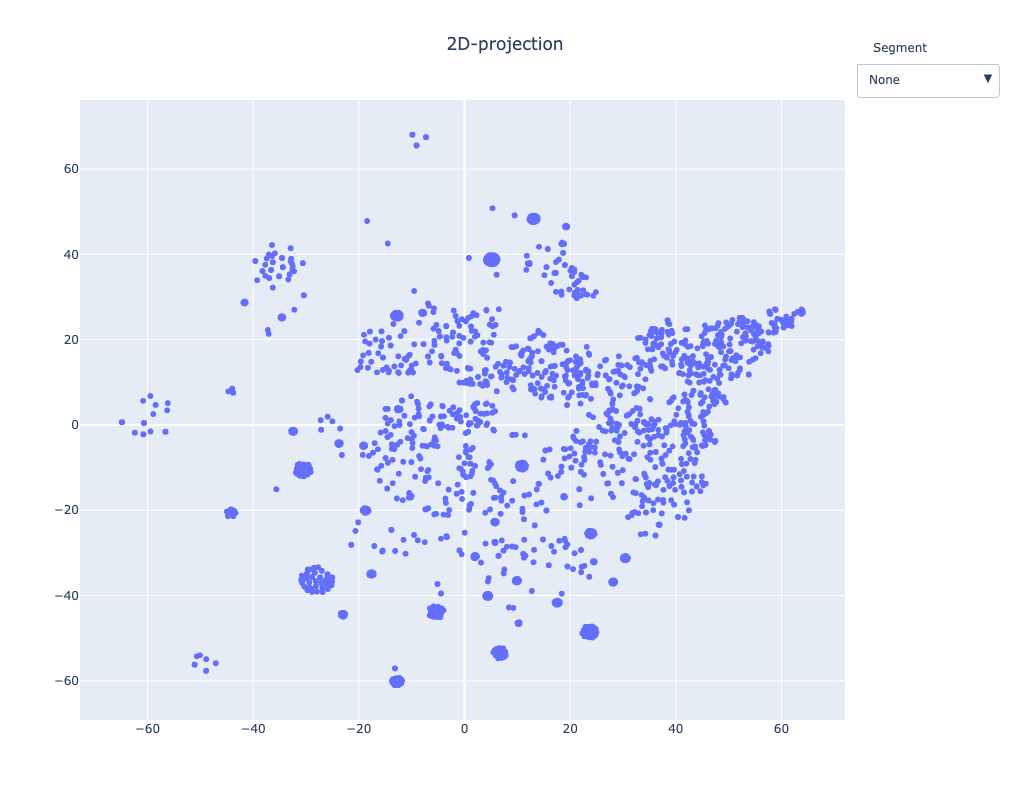

In [39]:
stream2.projection(features=features, sample_size=3000, random_state=42)